## Obtaining light curves for RR Lyrae stars in the PAL5 globular cluster

This notebook builds on the previous work of obtaining lightcurves for stars within the Palomar 5 globular cluster by refining the PSF photometry. This will be done by using the master mosaic image for the ePSF model and to build a source list using it due to its lower signal-to-noise ratio (SNR).

The aim is the compare each epoch to the master source list instead of epoch 1 as in the previous notebook and creating a consistent unique ID corresponding to each star across the epochs to make matching the stars easier. Failing this, then converting the sky coordinates into planar x, y coordinates for each epoch and using the master image to find the nearest star.

This will hopefully mean that light curves can be built with slighter higher accuracy by improving the photometry and also reducing the possibility of matching the stars between epochs incorrectly. A brief analysis to ensure there is no systematic error between epochs will be carried out and an attempt to find the standard deviation of stars detected and matched will be done and plotted to identify perhaps stars that vary (will have standard deviations errant compared to the rest of the stellar population).

The next phase in a different notebook is to create a master notebook and begin the process of folding the lightcurves to aid in identifying the periods of the RR Lyrae stars and so calculate their distances.

Contents:

1) list of imports

2) PSF Photometry: -ePSF model using mosaic image; -create master star list -PSF photometry using fixed centroids from the mosaic image on each epoch, saving the data in the filename format: PAL5_PSFphot_02_epochxx_channelxpxum.fits

3) Star matching: -convert both master and epoch coordinates into right ascension and declination values -match the stars between the two lists -copy star ID from master list to epoch list -join the tables together based on the master ID -loop for all epochs

4) Extract magnitudes and errors: -extract the magnitudes and errors for each suspected RRL and some random stars -systematic error analysis from random stars

5) Analysis: -calculate standard deviations and plot -investigate errant stars (could be RRLs)

6) Light curves: -plot and save all the lightcurves

7) Next steps: -prepare to extend lightcurves, fold them and find their periods

In [2]:
import math
import glob
import copy
import numpy as np
import pandas as pd
import astroalign as aa
import matplotlib
import matplotlib.pyplot as plt
from astropy import wcs
from astropy import units as u
from astropy.io import fits # used for FITS file management
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table, join
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import Angle
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground
from matplotlib.colors import LogNorm

%matplotlib inline

#### Building ePSF model using master mosaic image

FITS file information:
FILE = PAL5_data/PAL5__e1/PAL5__e1_4p5um.fits
DATE = 2013-05-10T21:50:03.531
FLUXCONV = 0.1447
EXPTIME = 81.4431




Number of ePSF sources found = 60



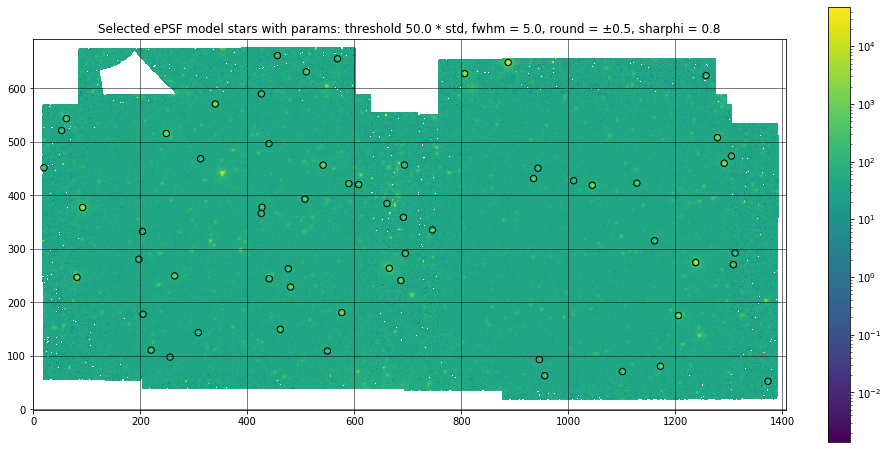

Number of refined ePSF sources = 41



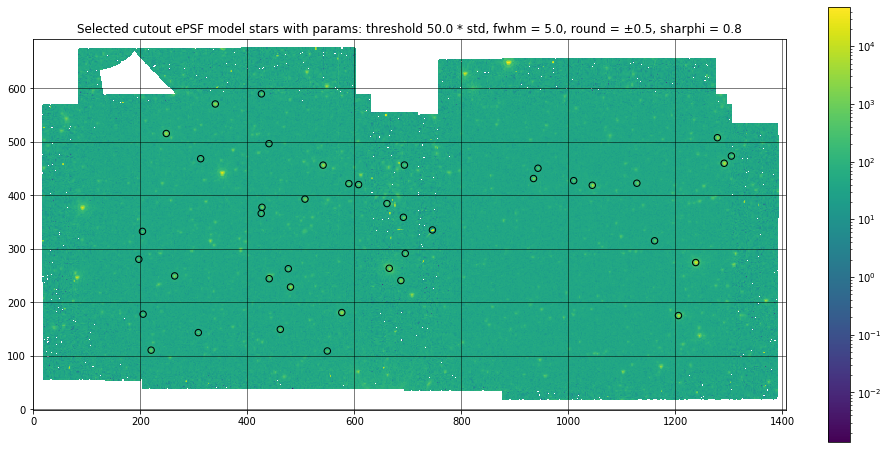

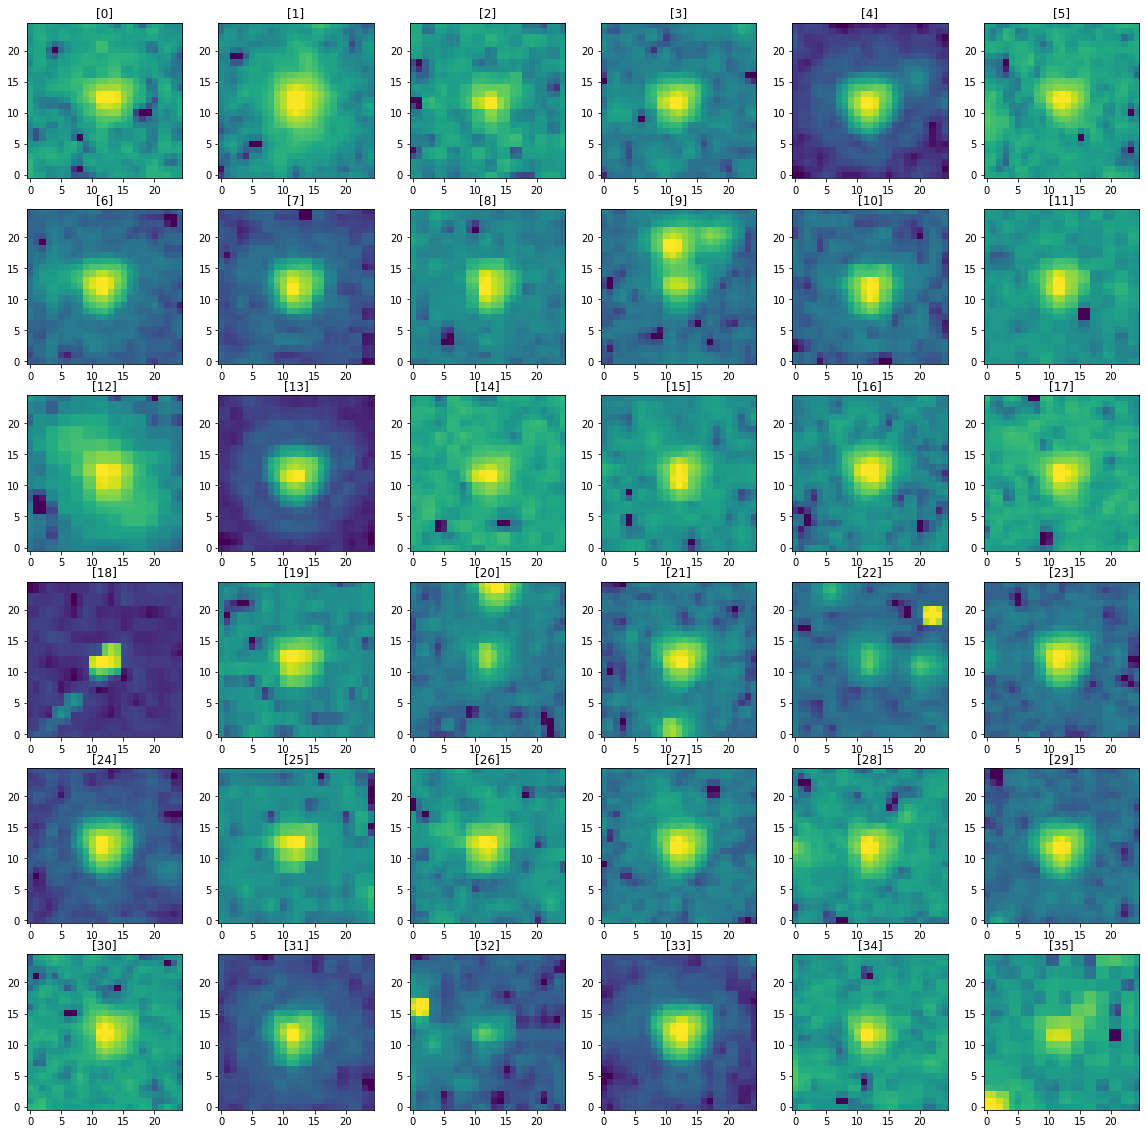

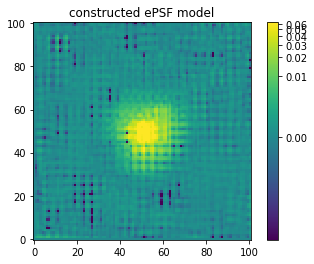

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
2 8 9 18 20 19 22 32 35


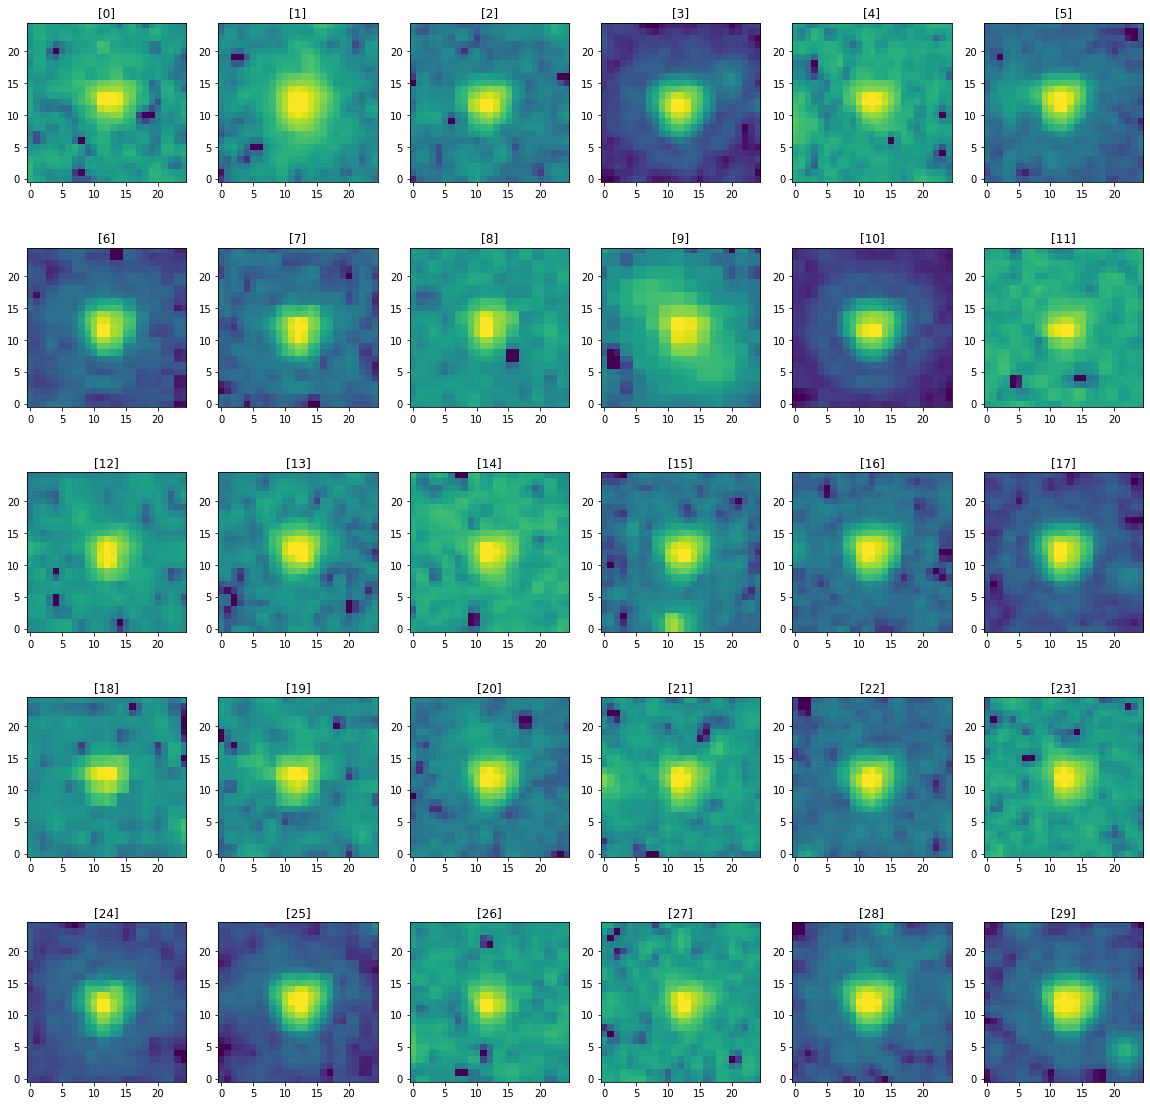

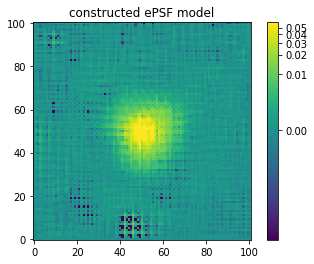

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
11 15


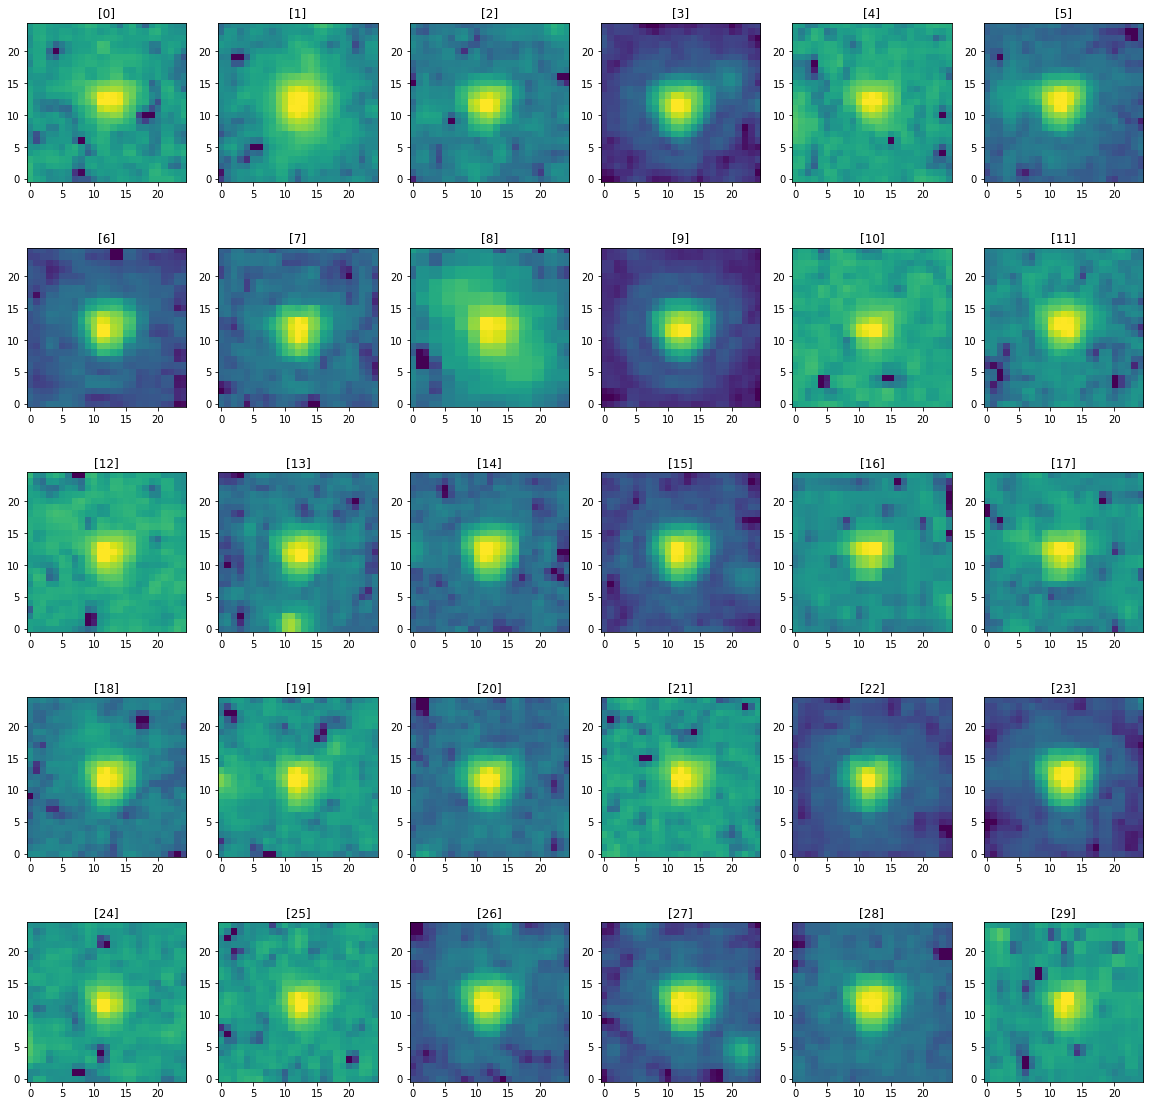

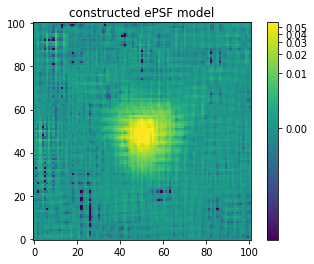

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
-99
Escape completed



In [46]:
## BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/*/'
general_dir = 'PAL5_data/'
channel = '4p5um'

## CHANNEL ##

if channel == '3p6um':
    aper_corr = 1.1233         # aperture correction for 337 (6,6,14) apertures in channel 1, given in IRAC handbook §4.10
    ap_err = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag = 18.80               # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err = 0.02            # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err = aper_corr * 0.02
    zmag = 18.32
    zmag_err = 0.02 
    
#____________________________________#
## BUILD ePSF MODEL USING ONE IMAGE ##

epoch_dir = 'PAL5_data/PAL5__e1/'  # specific epoch for ePSF
master_dir = 'PAL5_data/PAL5/'     # mosaic image for ePSF

epsf_file = epoch_dir+'PAL5__e1_'+channel+'.fits'
#epsf_file = master_dir+'PAL5_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(epsf_file) as header_list:
    header = header_list[0].header
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    time = Time(header['DATE_OBS'])
    counts = exptime / fluxconv
    image_data = fits.getdata(epsf_file, ext = 0)
    data = image_data * counts
    print('FITS file information:\nFILE = {0}\nDATE = {1}\nFLUXCONV = {2}\nEXPTIME = {3}\n\n'.format(epsf_file, time, fluxconv, exptime))

## PARAMETERS : ePSF ##

fwhm = 5.
sigma_val = 5.
model_threshold = 50.
roundlo = -0.5
roundhi = 0.5
sharphi = 0.8
do_plot = True

mean, median, std = sigma_clipped_stats(data, sigma = sigma_val) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = model_threshold * std, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
epsf_sources = starfind_init(data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

if do_plot == True:
    # PLOT SELECTED STARS TO TEST PARAMETERS #
    positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
    apertures = CircularAperture(positions, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    apertures.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Selected ePSF model stars with params: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(model_threshold, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    plt.close()

elif do_plot == False:
    pass

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

star_tbl = Table()      # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

if do_plot == True:
    # PLOT CUTOUT STARS TO BE USED IN EPSF MODEL #
    cutout_pos = np.transpose((star_tbl['x'], star_tbl['y']))
    cutout_apers = CircularAperture(cutout_pos, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    cutout_apers.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Selected cutout ePSF model stars with params: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(model_threshold, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    
elif do_plot == False:
    pass

## EXTRACT STARS ##

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = sigma_val)
epsf_data = data - median_val

while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 4, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)
    
    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

#### Building master star list from mosaic image and converting into (α, δ)

FITS file information:
FILE = PAL5_data/PAL5/PAL5_4p5um.fits
FLUXCONV = 0.1447
EXPTIME = 963.207




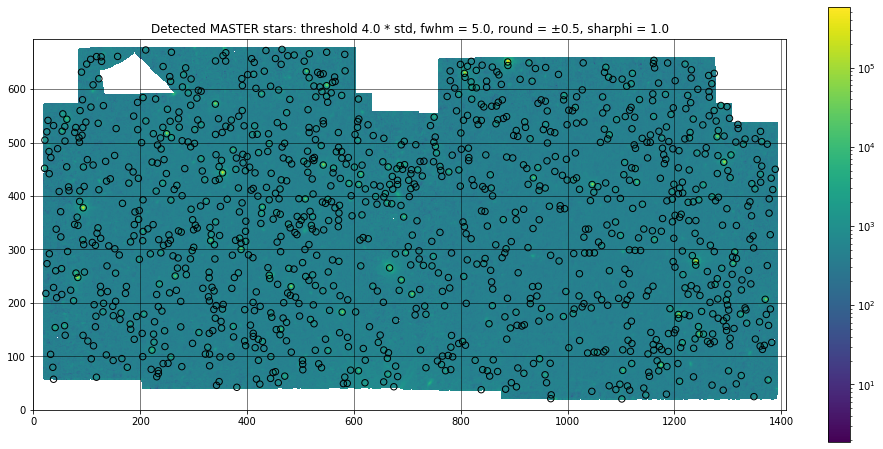

Number of MASTER stars detected = 1177



Number of MASTER stars found from PSF = 1246

       x_0                y_0         ...      flux_unc      iter_detected
------------------ ------------------ ... ------------------ -------------
  968.458391432972  20.72177414813355 ...  177.9345310077098             1
 969.3359075931846 27.832213992186933 ... 172.37245012858972             1
1101.5124302933175 20.188373230958135 ... 323.67800775033845             1
1348.7797423589093 24.565755167285015 ... 198.51634780344392             1
 1146.344447826931 27.501437625040154 ... 114.77478523492594             1
1142.5676041792424  40.58868125086741 ... 102.07671602966296             1
1185.0162236097424 29.148899612376336 ...  78.32105157525754             1
1045.3534647924407 34.438822764141555 ...  81.87509970452295             1
1116.2526441525292  36.75100235695786 ... 100.00260582600262             1
1090.3554984127047  37.74394278741798 ...  98.78963598603445             1
               ...                ... ...             

In [47]:
## BUILD MASTER STAR LIST USING MOSAIC ##

master_dir = 'PAL5_data/PAL5/'  # mosaic image for ePSF

master_file = master_dir+'PAL5_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(master_file) as header_list:
    master_header = header_list[0].header
    fluxconv = master_header['FLUXCONV']
    exptime = master_header['EXPTIME']
    counts = exptime / fluxconv
    image_data = fits.getdata(master_file, ext = 0)
    master_data = image_data * counts
    print('FITS file information:\nFILE = {0}\nFLUXCONV = {1}\nEXPTIME = {2}\n\n'.format(master_file, fluxconv, exptime))

## PARAMETERS FOR USE ON MASTER IMAGE ##

sigma_master = 4.
fwhm = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = 0.5
sharphi = 1.0
do_plot = False

## SOURCE DETECTION ON MASTER IMAGE ##

mean, median, std = sigma_clipped_stats(master_data, sigma = sigma_val)

master_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_master * std, roundlo = roundlo, roundhi = roundhi)
master_sources = master_daofind(master_data)

master_positions = np.transpose((master_sources['xcentroid'], master_sources['ycentroid']))
master_apertures = CircularAperture(master_positions, r = 6.)

plt.imshow(master_data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
master_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Detected MASTER stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
          .format(sigma_master, fwhm, roundhi, sharphi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()
plt.close()
print('Number of MASTER stars detected = {0}\n'.format(len(master_sources)))
    
## RENAMING STAR LIST TITLES ##

master_sources['xcentroid'].name = 'x_0'
master_sources['ycentroid'].name = 'y_0'
master_sources['id'].name = 'master_id'

## PSF PHOTOMETRY ON MASTER SOURCE ##

daogroup = DAOGroup(crit_separation = sigma_master * fwhm)
bkg_estimator = MMMBackground()
fitter = LevMarLSQFitter()

data_master_psf = np.nan_to_num(data, nan = 1**-7)

## FIXED CENTROIDS WRT TRANSFORMED MASTER POSITIONS ##

master_psf = np.transpose((master_sources['x_0'], master_sources['y_0']))
epsf.x_0.fixed = True
epsf.y_0.fixed = True
pos_master = Table(names = ['x_0', 'y_0'], data = master_psf)
    
## PERFORMING PSF PHOTOMETRY ##

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = master_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = bkg_estimator,
                                                    psf_model = epsf,
                                                    fitter = fitter,
                                                    niters = 3,
                                                    aperture_radius = 6.,
                                                    fitshape = (11, 11))

master_phot = PSF_photometry(image = data_master_psf, init_guesses = pos_master)
residual_image = PSF_photometry.get_residual_image()
    
print('Number of MASTER stars found from PSF = {0}\n'.format(len(master_phot)))
print(master_phot)  

## CONVERT COORDINATES ##

master_list = copy.copy(master_phot)
del master_list['flux_0', 'group_id', 'x_fit', 'y_fit', 'flux_fit', 'flux_unc', 'iter_detected']
master_list['id'].name = 'phot_id'

master_list['master_id'] = int(0)
for i in range(len(master_list)):
    master_list['master_id'][i] = i

del master_list['phot_id']
new_order = ['master_id', 'x_0', 'y_0']
master_list = master_list[new_order]

w = wcs.WCS(master_header)
coord = np.transpose((master_list['x_0'], master_list['y_0']))
world = w.wcs_pix2world(coord, 0)

m_ra, m_dec = world[:, 0], world[:, 1]
m_c = SkyCoord(m_ra, m_dec, frame = 'icrs', unit = 'deg')

master_list['ra'] = m_ra
master_list['dec'] = m_dec

## EXPORT PHOTOMETRY FILE AND PRINT TO SCREEN ##

master_list['master_id', 'x_0', 'y_0', 'ra', 'dec'].write(
    r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_PSFmaster_03_channel{0}.txt'.format(channel), format = 'csv', overwrite = True)
    
print(master_list['master_id', 'x_0', 'y_0', 'ra', 'dec'])
print('\n\n')

EPOCH NUMBER = 1

FITS file information:
FILE = PAL5_data\PAL5__e1\PAL5__e1_4p5um.fits
DATE = 2013-05-10T21:50:03.531
FLUXCONV = 0.1447
EXPTIME = 81.4431




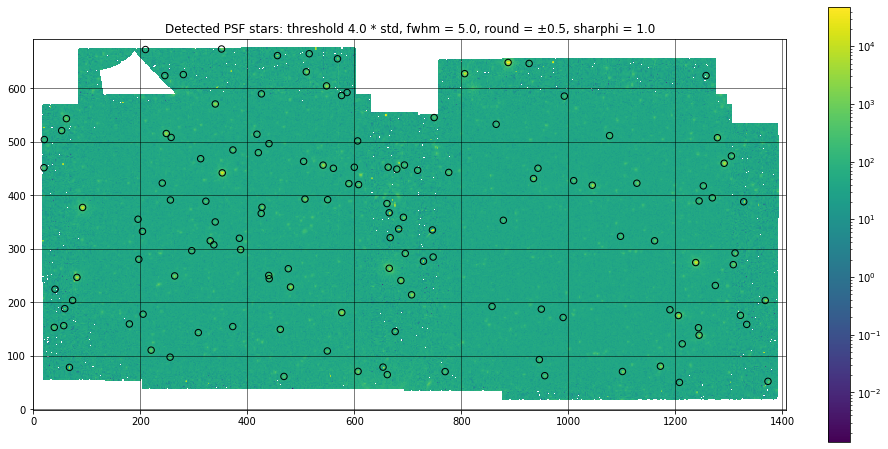

Number of stars detected = 137



Number of PSF stars found and analysed = 1265

 id        x_fit        ...    apparent_mag      apparent_mag_unc  
---- ------------------ ... ------------------ --------------------
   1  966.4357854523145 ...                nan                  nan
   2  967.3281089110301 ... 17.340522056658546  0.11570204474477178
   3 1099.4838366794625 ...                nan  0.21464613432202417
1178 1096.6491156890906 ...                nan                  nan
   4 1346.7512256888567 ... 17.224495839318138  0.10109459934192429
   5 1144.3294741166856 ... 17.381675047104647  0.04256168881040397
   6 1140.5800818342095 ... 17.871687682776315  0.06039282877955456
   7 1183.0032714042736 ...                nan                  nan
   8 1043.3566691643387 ... 19.402524641843367   0.2829611294321022
   9  1114.258076641498 ... 19.988309723663967   0.4930303459668734
 ...                ... ...                ...                  ...
   9  746.0398750698749 ... 11.656354847686941  0.05945855899007673
 

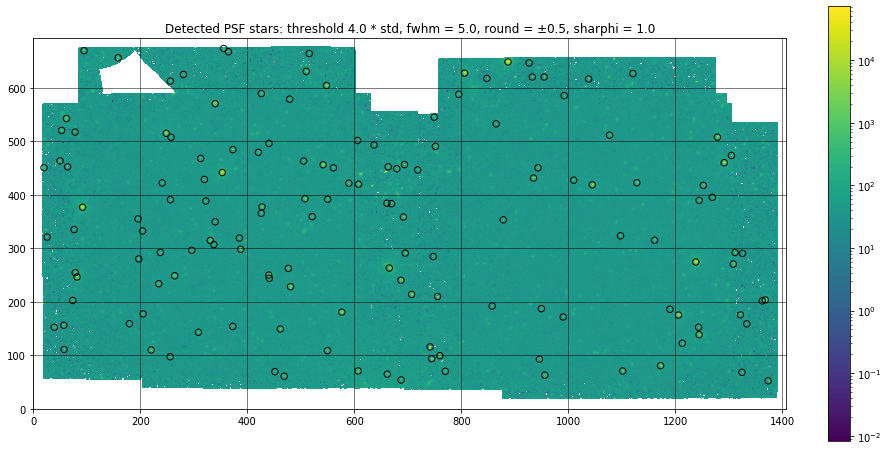

Number of stars detected = 147



Number of PSF stars found and analysed = 1280

 id        x_fit        ...    apparent_mag      apparent_mag_unc 
---- ------------------ ... ------------------ -------------------
   1  966.6117394246891 ...  19.20295189510569  0.5495442845436327
   2  967.5006913515631 ... 17.713579014095583  0.1378731104620481
   3  1099.661514363286 ...                nan 0.21912401919951435
1178 1096.8273413495838 ...                nan                 nan
   4 1346.9295537586456 ...  17.12055396881085 0.10658081279767952
   5  1144.504169551145 ...  17.30964380009009 0.05558180498821712
   6 1140.7485121633108 ...  17.59661109669702 0.06672257420009939
   7 1183.1776106909003 ...                nan                 nan
   8 1043.5269498534567 ...  19.33456453998085 0.25454544737510515
   9  1114.428041157937 ...                nan                 nan
 ...                ... ...                ...                 ...
  24    932.70184677446 ... 14.734291576327955  0.0595236083519831
  25  954.80338

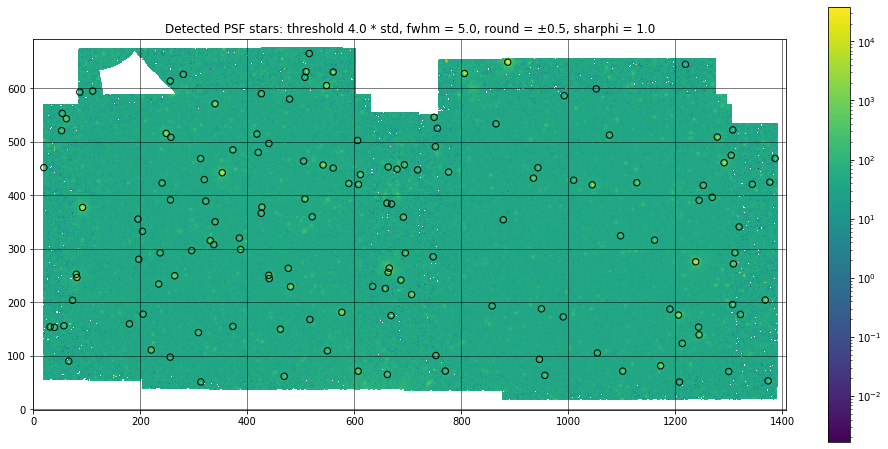

Number of stars detected = 147



Number of PSF stars found and analysed = 1270

 id        x_fit        ...    apparent_mag      apparent_mag_unc 
---- ------------------ ... ------------------ -------------------
   1  966.6502352932959 ...                nan                 nan
   2  967.5365749166392 ...  17.66918583730353 0.11711831877038474
   3 1099.6996014947322 ... 16.084434454127493 0.07042283707876744
1178 1096.8658882019158 ...                nan                 nan
   4 1346.9649119149408 ... 17.098560120576852 0.08067789391747987
   5 1144.5393703850596 ...  17.20326204604975 0.04174970511423624
   6  1140.778929369846 ... 17.700096439207194 0.05620462927377865
   7 1183.2120315191978 ...                nan                 nan
   8 1043.5600646078137 ...  19.33310931043143  0.2583653337586048
   9 1114.4599856743162 ... 20.637392533879645  0.7780893728407915
 ...                ... ...                ...                 ...
  14 1386.4798956095276 ... 13.807747875987726 0.05480422203151394
  15 1307.25621

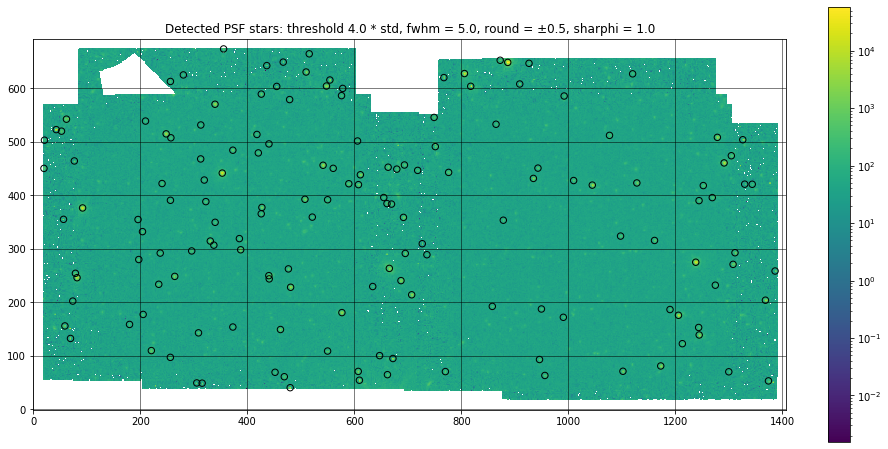

Number of stars detected = 155



Number of PSF stars found and analysed = 1281

 id        x_fit        ...    apparent_mag      apparent_mag_unc  
---- ------------------ ... ------------------ --------------------
   1   966.844966372086 ...                nan                  nan
   2  967.7293284672862 ... 17.535704568554888   0.0988364151161788
   3 1099.8879241456434 ...                nan   0.2172279091718156
1178 1097.0546817399854 ...                nan                  nan
   4 1347.1398646835974 ...  17.59760069918035  0.12740996518393394
   5 1144.7234954218352 ...  16.92481093771757 0.040140078526748016
   6 1140.9596802126025 ... 17.432838113472016  0.06773030892672133
   7 1183.3938036189097 ... 20.676005607559233   0.8496486979500834
   8 1043.7472766932528 ... 19.204782717073318  0.20169525035679095
   9    1114.6430766444 ...                nan                  nan
 ...                ... ...                ...                  ...
  25  261.5262717692323 ... 15.139561404313397  0.04077074257244175
 

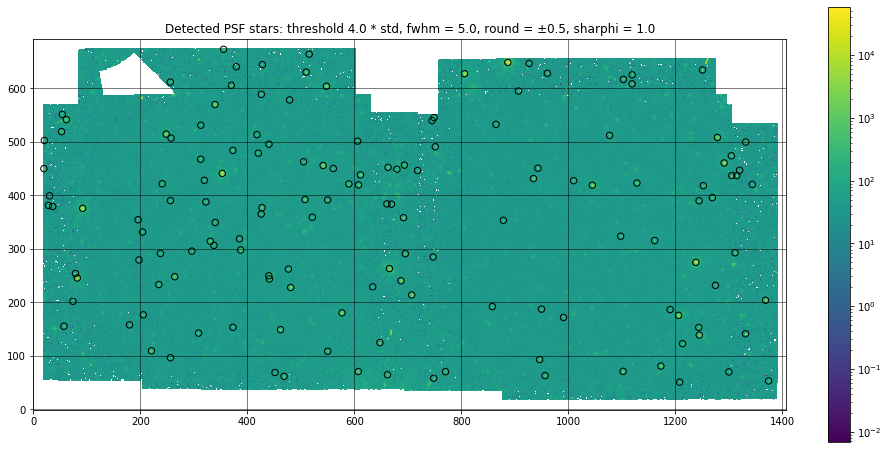

Number of stars detected = 147



Number of PSF stars found and analysed = 1278

 id        x_fit        ...    apparent_mag      apparent_mag_unc  
---- ------------------ ... ------------------ --------------------
   1  967.0540689039263 ...                nan                  nan
   2  967.9354011971924 ... 16.881487129207915  0.07491311269775171
   3 1100.1046613970425 ...                nan  0.16936025036813962
1178 1097.2717888184138 ...                nan                  nan
   4  1347.368465796003 ...  17.19433477133465  0.07587977213996412
   5 1144.9395609816106 ... 17.015629379895778  0.04666194360861932
   6 1141.1698691823772 ... 17.569725860844756  0.06986923010996221
   7 1183.6113077564064 ...                nan                  nan
   8 1043.9547189224868 ... 18.642014460357686  0.15751184470490978
   9 1114.8534629351516 ...                nan                  nan
 ...                ... ...                ...                  ...
  22 369.89805540681317 ... 13.621579987199032 0.049352116335165175
 

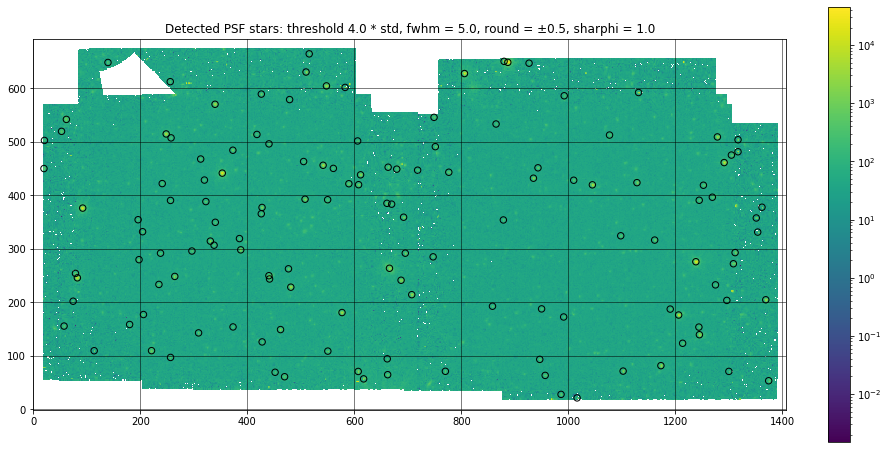

Number of stars detected = 137



Number of PSF stars found and analysed = 1273

 id        x_fit        ...    apparent_mag      apparent_mag_unc  
---- ------------------ ... ------------------ --------------------
   1  967.3166546391604 ... 12.052398499120413  0.06673573830882978
   2  968.1947091496422 ...  17.25424628643801    8.175381194906915
   3  1100.367261704112 ...                nan   0.2177902557664292
1178 1097.5349553332348 ...                nan                  nan
   4 1347.6286194837685 ... 17.102994079132525  0.06470944491104687
   5   1145.19871376543 ...  17.46223695619475 0.053963993441380934
   6 1141.4229983555083 ... 18.130190279583818  0.09170886781699658
   7  1183.869634245505 ...                nan                  nan
   8 1044.2108506736463 ...                nan                  nan
   9 1115.1084061114043 ... 20.620266383908955   1.0586493452348305
 ...                ... ...                ...                  ...
  17  1317.074093772272 ... 13.452373117477492  0.04334098844920196
 

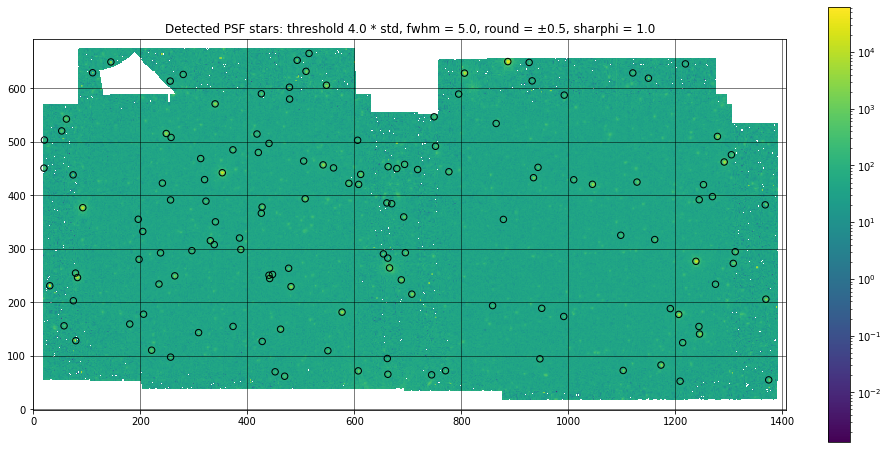

Number of stars detected = 139



Number of PSF stars found and analysed = 1269

 id        x_fit        ...    apparent_mag      apparent_mag_unc  
---- ------------------ ... ------------------ --------------------
   1  967.5528650696132 ...   18.5416683955904   0.3149080399105766
   2  968.4288279666185 ... 17.376889095507714  0.10636680260403332
   3 1100.6056045663686 ...  16.33200745778937   0.0777225332932885
1178  1097.773616728608 ...                nan                  nan
   4  1347.869336171911 ...  17.00141210954951  0.04991678934768176
   5 1145.4355573326943 ... 17.161995224137762  0.04841051799316958
   6   1141.65591214928 ... 17.927092269099404  0.08575663597970103
   7 1184.1065640736542 ...                nan                  nan
   8 1044.4441421009078 ...  19.70485888322571  0.40445965348457497
   9 1115.3420653094781 ... 19.431117715029643  0.27212511091228575
 ...                ... ...                ...                  ...
  13  74.29817284707886 ... 15.020517864218009  0.07590060986332914
 

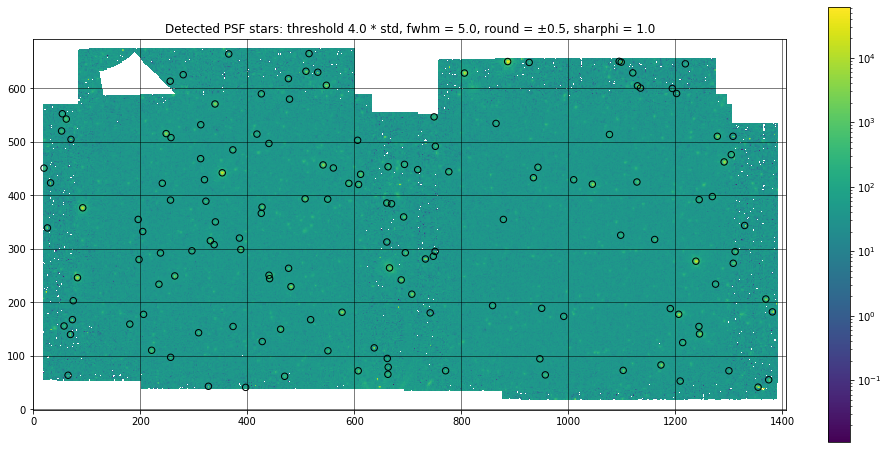

Number of stars detected = 151



Number of PSF stars found and analysed = 1293

 id        x_fit        ...    apparent_mag      apparent_mag_unc  
---- ------------------ ... ------------------ --------------------
   1   967.539059706054 ...                nan                  nan
   2  968.4126742850015 ...   17.5133216978375   0.1102894765211061
   3 1100.5830504679266 ...  16.32663724019142  0.06876068726040253
1178 1097.7516447510184 ...                nan                  nan
   4  1347.828794796199 ... 17.142047236011997 0.060578364071837906
   5 1145.4076427845853 ... 17.399824030614965  0.05484354197303989
   6 1141.6240368632575 ... 17.804096989749226  0.07489918613416294
   7 1184.0755263471133 ...                nan                  nan
   8  1044.420764635297 ... 20.159064524676275   0.5807757771014626
   9 1115.3131899771552 ...  19.19156193377323   0.2455324074828001
 ...                ... ...                ...                  ...
  37  1098.809530782098 ... 13.981000986547413  0.04531486149797131
 

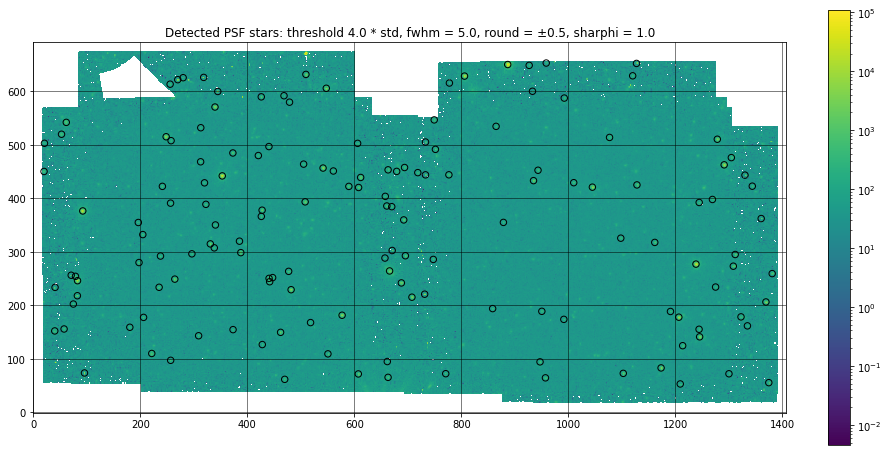

Number of stars detected = 151



Number of PSF stars found and analysed = 1279

 id        x_fit        ...    apparent_mag      apparent_mag_unc  
---- ------------------ ... ------------------ --------------------
   1  967.8004261431867 ... 18.850184685644493  0.36309383395615585
   2  968.6712263125304 ... 17.623285984071835    0.115998208323686
   3 1100.8540461789576 ... 15.937172511824016  0.04999510761003443
1178 1098.0229328786793 ...                nan                  nan
   4 1348.1155136651048 ... 16.869006308420374  0.06569775101212189
   5 1145.6788518684552 ...  17.37401784358484  0.06077393212420182
   6 1141.8896843580596 ... 17.799110024111044  0.09426779783206801
   7 1184.3488049620792 ...  19.30127847098303  0.29854288784219823
   8  1044.682022186027 ...                nan                  nan
   9 1115.5785282192005 ... 18.721888895937095   0.1446774433041154
 ...                ... ...                ...                  ...
  23  777.3800249898112 ... 16.416959445506514  0.06487035510514336
 

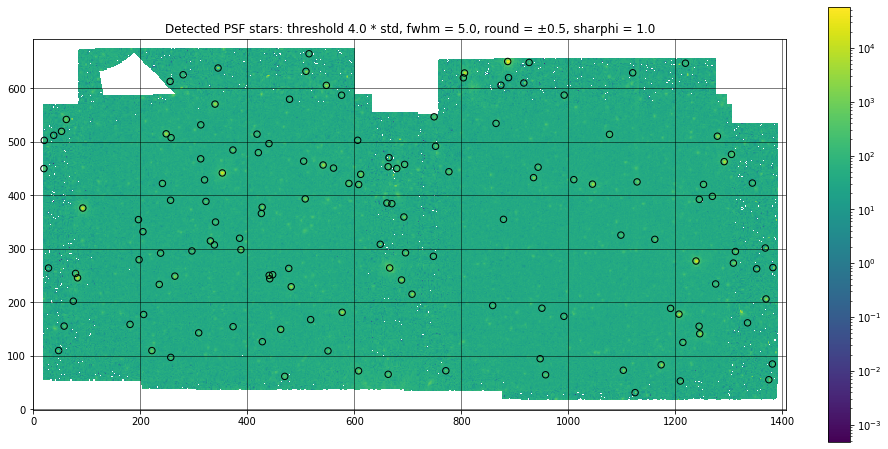

Number of stars detected = 144



Number of PSF stars found and analysed = 1267

 id        x_fit        ...    apparent_mag      apparent_mag_unc  
---- ------------------ ... ------------------ --------------------
   1  968.0393895825008 ... 21.582113815383547    4.994096663363294
   2  968.9081457819467 ...  17.72762202157678  0.14623247166154374
   3 1101.0975352897335 ...  16.16142040902187  0.06880736314014453
1178 1098.2666840720422 ...                nan                  nan
   4 1348.3658482361084 ... 17.015264286148888  0.05743422591725281
   5 1145.9216816329304 ...   16.9994420491529   0.0549213766684435
   6 1142.1285749582012 ... 17.500279481248366  0.08595881766361207
   7 1184.5924246481309 ...  20.38441874658473   0.7761923016552055
   8 1044.9195125439915 ... 19.048813854785767  0.21594269042805506
   9  1115.817673237697 ...  19.87077759017901   0.5130259535209184
 ...                ... ...                ...                  ...
  11  676.7182005301086 ... 14.623083728359347  0.05032867476864978
 

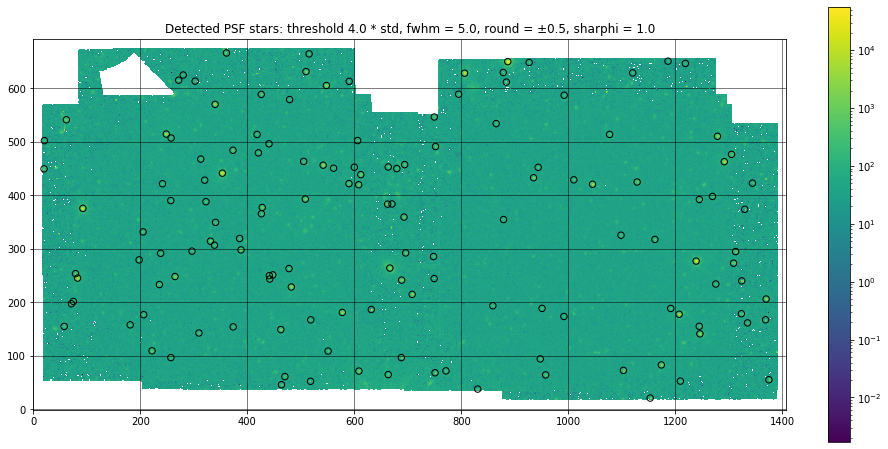

Number of stars detected = 143



Number of PSF stars found and analysed = 1280

 id        x_fit        ...    apparent_mag      apparent_mag_unc  
---- ------------------ ... ------------------ --------------------
   1  968.3096503982857 ... 18.598076434209098   0.2684686491240475
   2   969.175797747206 ... 18.080494071021974  0.18157847687572512
   3 1101.3684236051054 ...  16.21842302148403   0.0661279434982651
1178  1098.538010634601 ...                nan                  nan
   4  1348.635930764608 ...  17.41308613224369  0.08571191819401733
   5 1146.1900292453065 ... 17.257021957112997  0.05261037744395944
   6 1142.3921033158063 ... 17.640815414501635  0.06857260170352078
   7 1184.8602925774353 ...                nan                  nan
   8 1045.1849844451863 ... 19.437145154142396   0.2762046080162027
   9 1116.0825258360223 ... 19.587141652876905   0.3803931140783054
 ...                ... ...                ...                  ...
  27  878.2502909989623 ...  15.16564030341836  0.33503488869090287
 

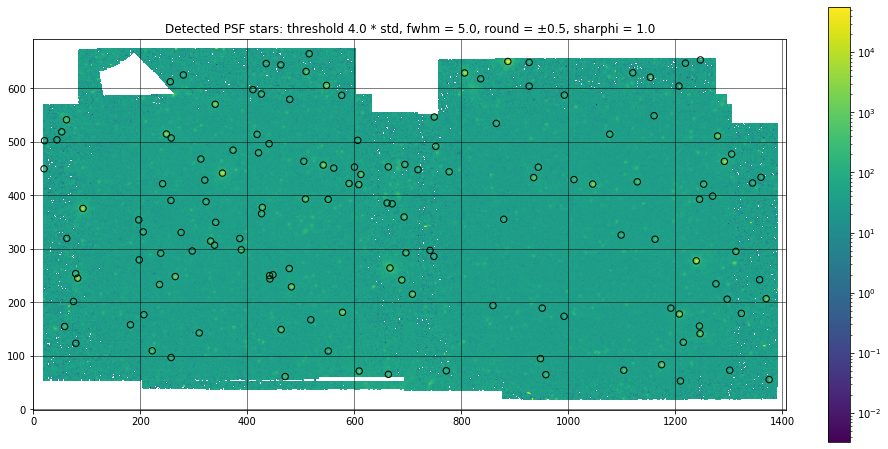

Number of stars detected = 146



Number of PSF stars found and analysed = 1278

 id        x_fit        ...    apparent_mag      apparent_mag_unc  
---- ------------------ ... ------------------ --------------------
   1  968.7240967665816 ... 19.256892006342266  0.46592365723006174
   2  969.5874706501897 ... 17.565546978393083  0.09569108255050414
   3 1101.7851323078628 ...   16.5535493254576  0.07932633827394549
1178 1098.9551530982405 ...                nan                  nan
   4 1349.0547394879716 ... 17.571706401339455   0.0800550661451815
   5 1146.6045633589385 ...  17.05663282605088  0.04648393206644484
   6 1142.8014494718607 ... 17.530518288134907  0.07307549844325736
   7 1185.2747777270426 ...                nan                  nan
   8 1045.5952409101574 ... 19.347013974966927    0.236239919376564
   9  1116.492970121054 ... 18.307162150538293  0.09813965351171981
 ...                ... ...                ...                  ...
  22   808.469211030893 ... 14.214859480372949  0.18966549517106224
 

In [48]:
## PSF PHOTOMETRY ON ALL EPOCHS ##

## PARAMETERS ##

sigma_psf = 4.
fwhm = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = 0.5
sharphi = 1.0
do_plot = False

## EPOCH LOOP COUNTER ##

epoch = 0

## COPY MASTER TABLE AS MAIN TABLE ##

#main_table = copy.copy(master_sources)
main_table = copy.copy(master_list)

## STORING EPOCH TIMES AS MODIFIED JULIAN DATE VALUES ## #could refine/update later?

epoch_time = []

## PSF PHOTOMETRY LOOP ##
for file in glob.glob(base_dir+'PAL5__e[0-9]_'+channel+'.fits', recursive = True) + glob.glob(base_dir+'PAL5__e[0-9][0-9]_'+channel+'.fits', recursive = True):
    epoch += 1
    print('EPOCH NUMBER = {0}\n'.format(epoch))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as header_list:
        header = header_list[0].header
        fluxconv = header['FLUXCONV']
        exptime = header['EXPTIME']
        time = Time(header['DATE_OBS'])
        counts = exptime / fluxconv
        
        image_data = fits.getdata(file, ext = 0)
        data = image_data * counts
        
        print('FITS file information:\nFILE = {0}\nDATE = {1}\nFLUXCONV = {2}\nEXPTIME = {3}\n\n'.format(file, time, fluxconv, exptime))

    ## EXTRACT TIME FROM EPOCH ##
    
    epoch_time.append(Time(header['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
    
    ## EXTRACTING LOC-DEPENDENT CORRECTIONS ##
    corr_file = general_dir+'PAL5__e'+str(epoch)+'/PAL5__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(corr_file) as hdu_list:
        corr_data = hdu_list[0].data
    
    ## SOURCE DETECTION ON IMAGE ## 
    psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_psf * std, roundlo = roundlo, roundhi = roundhi)
    psf_sources = psf_daofind(data)

    psf_positions = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
    psf_apertures = CircularAperture(psf_positions, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    psf_apertures.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Detected PSF stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(sigma_psf, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    plt.close()
    print('Number of stars detected = {0}\n'.format(len(psf_sources)))
    
    ## GROUP ##

    psf_sources['xcentroid'].name = 'x_0'
    psf_sources['ycentroid'].name = 'y_0'
    
    ## ALIGN THE MASTER POSITIONS TO THE EPOCH FRAME ##
    
    #master_pos = np.transpose((master_sources['x_0'], master_sources['y_0']))
    #tf, (tf_source, tf_target) = aa.find_transform(master_data, data)
    #master_tf = aa.matrix_transform(master_pos, tf.params)
    master_pos = np.transpose((master_list['x_0'], master_list['y_0']))
    tf, (tf_source, tf_target) = aa.find_transform(master_data, data)
    master_tf = aa.matrix_transform(master_pos, tf.params)

    daogroup = DAOGroup(crit_separation = sigma_psf * fwhm)
    bkg_estimator = MMMBackground()
    fitter = LevMarLSQFitter()

    data_psf = np.nan_to_num(data, nan = 1**-7)

    ## FIXED CENTROIDS WRT TRANSFORMED MASTER POSITIONS ##

    epsf.x_0.fixed = True
    epsf.y_0.fixed = True
    pos = Table(names = ['x_0', 'y_0'], data = master_tf)
    
    ## PERFORMING PSF PHOTOMETRY ##

    PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                        group_maker = daogroup,
                                                        bkg_estimator = bkg_estimator,
                                                        psf_model = epsf,
                                                        fitter = fitter,
                                                        niters = 3,
                                                        aperture_radius = 6.,
                                                        fitshape = (11, 11))

    result_phot = PSF_photometry(image = data_psf, init_guesses = pos)
    residual_image = PSF_photometry.get_residual_image()
    
    #hdu = fits.PrimaryHDU(residual_image)
    #hdul = fits.HDUList([hdu])
    #hdul.writeto('residual_image_08_fixed_centroids.fits')
    print('Number of PSF stars found and analysed = {0}\n'.format(len(result_phot)))
    
    if do_plot == True:
        ## VISUALISE PSF IMAGE AND RESIDUALS ##
        plt.subplot(1, 2, 1)
        plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
        plt.title('input data')
        plt.colorbar(orientation = 'horizontal')

        plt.subplot(1, 2, 2)
        plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
        plt.title('residual image')
        plt.colorbar(orientation = 'horizontal')
        plt.gcf().set_size_inches(20, 14)
        plt.show()
        plt.close()
    elif do_plot == False:
        pass
    
    phot = result_phot   # REDEFINE PHOTOMETRY TABLE FOR EASE
    #print(phot)
    
    ## PHOTOMETRY: UNCERTAINTIES ##
    
    PSF_err = phot['flux_unc']
    PSF_flux = phot['flux_fit'] 
    
    ## APPARENT MAGNITUDES ##
    
    phot['apparent_mag'] = float('NaN')
    for i in range(0, len(phot)):
        # APPLY ARRAY-LOC DEP CORRECTION
        loc_corr = corr_data[int(phot['y_fit'][i])][int(phot['x_fit'][i])]
        if phot['flux_fit'][i] >= 0:
            phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)
    
    ## APPARENT MAGNITUDE: UNCERTAINTIES ##
    
    phot['apparent_mag_unc'] = float('Nan')
    for i in range(0, len(phot)):
        if phot['flux_fit'][i] >= 0:
            phot['apparent_mag_unc'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
    
    ## CONVERT COORDINATES ##
    
    w = wcs.WCS(header)
    coord = np.transpose((phot['x_fit'], phot['y_fit']))
    world = w.wcs_pix2world(coord, 0)

    e_ra, e_dec = world[:, 0], world[:, 1]
    e_c = SkyCoord(e_ra, e_dec, frame = 'icrs', unit = 'deg')

    phot['ra'] = e_ra
    phot['dec'] = e_dec
    
    ## APPEND APPARENT MAGNITUDE AND UNCERTAINTY COLUMNS FOR EACH EPOCH ##
    
    epoch_table = copy.copy(phot)
    # DELETE CERTAIN COLUMNS TO AVOID CRAMMING NEW EPOCH TABLE
    del epoch_table['x_0', 'y_0', 'flux_0', 'flux_unc', 'iter_detected']
    epoch_mag = 'mag_epoch'+str(epoch)
    epoch_unc = 'unc_epoch'+str(epoch)
    epoch_ra = 'ra_epoch'+str(epoch)
    epoch_dec = 'dec_epoch'+str(epoch)
    # RENAME COLUMNS FOR EASE
    epoch_table.rename_column('ra', epoch_ra)
    epoch_table.rename_column('dec', epoch_dec)
    epoch_table.rename_column('apparent_mag', epoch_mag)
    epoch_table.rename_column('apparent_mag_unc', epoch_unc)

    ## EXPORT PHOTOMETRY FILE AND PRINT TO SCREEN ##
    phot['id', 'ra', 'dec', 'apparent_mag', 'apparent_mag_unc'].write(
        r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_PSFphot_04_epoch{0}_channel{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
    
    print(phot['id', 'x_fit', 'y_fit', 'ra', 'dec', 'apparent_mag', 'apparent_mag_unc'])
    print('\n\n')

    ## PHOTOMETRY COMPLETE -- APPARENT MAGNITUDES AND UNCERTAINTIES OBTAINED FOR ALL EPOCHS ##

    ## MATCH STARS FROM EPOCHS TO MASTER STAR LIST ##

    temp_table = copy.copy(main_table)
    
    w = wcs.WCS(header)
    coord = np.transpose((epoch_table['x_fit'], epoch_table['y_fit']))
    world = w.wcs_pix2world(coord, 0)

    ra, dec = world[:, 0], world[:, 1]
    c = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')

    epoch_table['ra'] = ra
    epoch_table['dec'] = dec
    
    idx, d2d, d3d = c.match_to_catalog_sky(m_c)
    
    # ENSURE MATCHES ARE SIGNIFICANT
    radius = 0.0001
    selection = (d2d > radius*u.deg)
    match_index = idx
    match_index[selection] = -99.
    matches = (match_index >= 0)
    
    temp_table = temp_table[match_index][matches]
    epoch_table = epoch_table[matches]
    
    # ASSIGN EPOCH TABLE ID EQUIVALENT TO MASTER ID
    epoch_table['master_id'] = temp_table['master_id']
    
    main_table = join(main_table, epoch_table['master_id', epoch_ra, epoch_dec, epoch_mag, epoch_unc], keys = 'master_id', join_type = 'left')
    
    #if epoch == 1:
    #    del main_table['sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
    #else:
    #    pass
    
    print(main_table)
    
    main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_main_03_epoch{0}_channel{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)

 id      ra         dec     period  ra_deg  dec_deg 
--- ----------- ----------- ------ ------- ---------
  0 15:15:57.18 -00:06:53.3 0.2932 228.988 -0.114806
  1 15:15:57.95 -00:11:23.4 0.3325 228.991 -0.189833
  2 15:16:12.76 -00:10:03.3   0.33 229.053 -0.167583
  3 15:16:05.79 -00:11:12.7 0.2864 229.024 -0.186861
  4 15:15:58.23 -00:05:47.4 0.2524 228.993   -0.0965
960


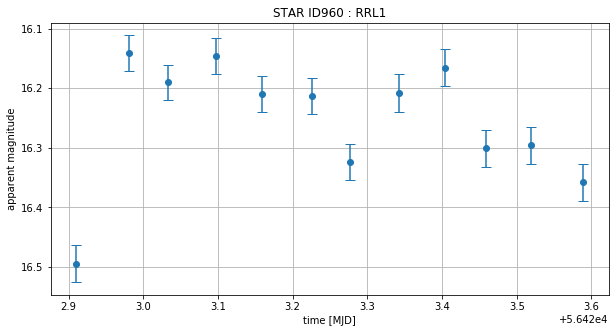

[0.30069267 0.54153454 0.72303841 0.93884543 0.14989989 0.3783142
 0.55389701 0.77436098 0.98631737 0.171887   0.37933534 0.61731173]
[0.30069267 0.54153454 0.72303841 0.93884543 0.14989989 0.3783142
 0.55389701 0.77436098 0.98631737 0.171887   0.37933534 0.61731173
 1.30069267 1.54153454 1.72303841 1.93884543 1.14989989 1.3783142
 1.55389701 1.77436098 1.98631737 1.171887   1.37933534 1.61731173
 2.30069267 2.54153454 2.72303841 2.93884543 2.14989989 2.3783142
 2.55389701 2.77436098 2.98631737 2.171887   2.37933534 2.61731173]


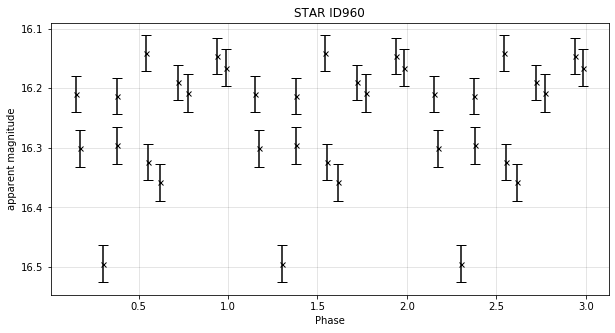

In [73]:
## IDENTIFYING RRL FROM CATALOGUE ##
main_file = r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_main_03_epoch12_channel3p6um.txt'
main_table = ascii.read(main_file, delimiter = ',', data_start = 1)

# CATALOGUE: http://www.astro.utoronto.ca/~cclement/index.html
# CREDIT: CHRISTINE CLEMENT

rrl_cat = 'CCVS_data/CCVS_PAL5_RRLs_data.txt'
df_cat = ascii.read(rrl_cat, delimiter = ',', data_start = 1)

# INITIALIZE COLUMNS FOR CONVERTING RIGHT ASCENSION AND DECLINATION FOR COMPARISON TO STAR LIST
# RIGHT ASCENSION TO BE CONVERTED FROM HOURS:MINUTES:SECONDS TO DECIMAL DEGREES
# DECLINATION TO BE CONVERTED FROM DEGRESS:MINUTES:SECONDS TO DECIMAL DEGREES
df_cat['ra_deg'] = str('null')
df_cat['dec_deg'] = str('null')
    
# CONVERTING STRING COLUMNS IN TABLES INTO OBJECT
for col in df_cat.itercols():
    if col.dtype.kind in 'SU':
        df_cat.replace_column(col.name, col.astype('object'))

# PERFORMING CONVERSIONS
for i in range(len(df_cat)):
    ra_hms = Angle(df_cat['ra'][i], u.hour)
    df_cat['ra_deg'][i] = ra_hms.to_string(unit = u.deg, decimal = True)
for i in range(len(df_cat)):
    dec_hms = Angle(df_cat['dec'][i], u.degree)
    df_cat['dec_deg'][i] = dec_hms.to_string(unit = u.deg, decimal = True)
print(df_cat)
df_cat.write('CCVS_data/CCVS_PAL5_RRLs_data_readin.txt', format = 'csv', overwrite = True)

cc_cat = pd.read_csv('CCVS_data/CCVS_PAL5_RRLs_data_readin.txt', sep = ',', header = 0)
coord_rrl_cat = SkyCoord(cc_cat['ra_deg'], cc_cat['dec_deg'], unit = u.degree)
c_cat = SkyCoord(main_table['ra'], main_table['dec'], unit = u.degree)

req_rrl = 0 # INPUT 0-4 CORRESPONDING TO RRL ID FROM CC CATALOGUE
c = coord_rrl_cat[req_rrl]

seps = []
for i in range(len(c_cat)):
    seps.append(c_cat[i].separation(c).value)

id_rrl = np.asarray(seps).argmin()
print(id_rrl)
seps = np.array(seps)

## LIGHT CURVES: PLOTTING ##

mag = []
mag_err = []

star_id = id_rrl
RRL = req_rrl + 1

#rand_star = 'id'

for i in range(1, 13):
    epoch = i
    mag.append(main_table[star_id]['mag_epoch'+str(i)])

for j in range(1, 13):
    epoch = j
    mag_err.append(main_table[star_id]['unc_epoch'+str(j)])

plt.plot(epoch_time, mag, color = 'k', linestyle = 'None', markersize = 5)
plt.errorbar(x = epoch_time, y = mag, xerr = None, yerr = mag_err, fmt = 'o', capsize = 5)
plt.title('STAR ID{0} : RRL{1}'.format(star_id, RRL))
plt.xlabel('time [MJD]')
plt.ylabel('apparent magnitude')
plt.grid()
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10, 5)
plt.savefig('lc_figs\lc_star_{0}_RRL_{1}_{2}_attempt_001'.format(star_id, RRL, channel), dpi = 500)
plt.show()
plt.close()

is_rrl = 'y'

phase = []

if is_rrl == 'y':
    P = cc_cat['period'][req_rrl]
    for i in epoch_time:
        func = i / P
        phase_val = func - np.floor(func)
        phase.append(phase_val)
    
    id_star, d2d, d3d = c.match_to_catalog_sky(c_cat)
else:
    star_id = rand_star
    phase = epoch_time

main_table_ma = copy.copy(main_table.filled(-99))

mag = []
mag_err = []
for i in range(1, 13):
    epoch = i
    mag.append(main_table_ma[star_id]['mag_epoch'+str(i)])

for j in range(1, 13):
    epoch = j
    mag_err.append(main_table_ma[star_id]['unc_epoch'+str(j)])

mag = np.ma.array(mag)
mag = np.ma.masked_where(mag == -99, mag)
mag_err = np.ma.array(mag_err)
mag_err = np.ma.masked_where(mag_err == -99, mag_err)
phase = np.ma.masked_array(phase, mag.mask)

mags_multi = np.concatenate((mag, mag, mag))
err_multi = np.concatenate((mag_err, mag_err, mag_err))
print(phase)
phase_multi = np.concatenate((phase, phase + 1., phase + 2.))
print(phase_multi)

plt.errorbar(x = phase_multi, y = mags_multi, xerr = None, yerr = err_multi, fmt = 'kx', markersize = 5, capsize = 5)
plt.title('STAR ID{0}'.format(star_id))
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
if is_rrl == 'y':
    plt.xlabel('Phase')
else:
    plt.xlabel('time [MJD]')
plt.ylabel('apparent magnitude')
plt.gcf().set_size_inches(10, 5)
plt.show()